# Work preparation

## libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.preprocessing import StandardScaler

In [3]:
from scipy.stats import f_oneway
from statsmodels.multivariate.manova import MANOVA
from scipy.stats.mstats import kruskal
import scikit_posthocs as sp

In [4]:
ppalette={'senior academics':'r', 'students':'g'}

## data import and preprocessing

In [5]:
students = pd.read_csv('students.tsv',sep='\t' )
dolgolets = pd.read_csv('dolgolets.tsv', sep = '\t')

In [6]:
students.columns = ['ID', 'квота сек', 'Слово', 'Предыдущее + слово', 'Первая_буква',
       'Стратегия', 'Порядок_буква', 'Порядок_весь_тест', 'Частотность',
       'Пауза', 'VP', 'VS', 'N of words', 'N of words_P', 'N of words_O',
       'N of words_S', 'Mean pause']

dolgolets.loc[(dolgolets['ID']=='pr_A_1') & (dolgolets['Слово']=='оква'), 'Стратегия']=11
dolgolets.loc[(dolgolets['ID']=='pr_G_1') & (dolgolets['Стратегия']=='9'),'Стратегия']=1
dolgolets.loc[(dolgolets['ID']=='pr_I_1') & (dolgolets['Стратегия']=='9'),'Стратегия']=3
dolgolets.loc[(dolgolets['ID']=='pr_K_1') & (dolgolets['Стратегия']=='9'),'Стратегия']=2
dolgolets.loc[(dolgolets['ID']=='pr_L_1') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='овеин'),'Стратегия']=8
dolgolets.loc[(dolgolets['ID']=='pr_L_1') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='сапан'),'Стратегия']=8
dolgolets.loc[(dolgolets['ID']=='pr_M_2') & (dolgolets['Стратегия']=='9') ,'Стратегия']=8
dolgolets.loc[(dolgolets['ID']=='pr_N_2') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='олелуй'),'Стратегия']=1
dolgolets.loc[(dolgolets['ID']=='pr_N_2') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='сопсизм'),'Стратегия']=8
dolgolets.loc[(dolgolets['ID']=='pr_S_1') & (dolgolets['Стратегия']=='9') ,'Стратегия']=4
dolgolets.loc[(dolgolets['ID']=='pr_T_1') & (dolgolets['Стратегия']=='9') ,'Стратегия']=8


dolgolets.loc[(dolgolets['ID']=='pr_N_2') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='перл'), 'Стратегия' ]=8
dolgolets.loc[(dolgolets['ID']=='pr_L_1') & (dolgolets['Стратегия']=='9') & (dolgolets['Слово']=='скрип'),'Стратегия'] = 11

dolgolets = dolgolets[students.columns]
dolgolets['type'] = 'senior academics'
students['type'] = 'students'

df = pd.concat([students, dolgolets])
df = df[df['квота сек']<=3]
df['Стратегия'] = df['Стратегия'].astype(str)
#df[df['Стратегия'].notnull()].Стратегия.astype('int32', errors = 'ignore')
df['Стратегия'] = df['Стратегия'].str.replace(r'.0', '')
df['Частотность'] = df['Частотность'].str.replace(r',', '.')
df['Частотность'] = df['Частотность'].astype('float', errors = 'ignore')
df['Пауза'] = df['Пауза'].str.replace(r',', '.')
df['Пауза'] = df['Пауза'].astype('float', errors='ignore' )
df['Порядок_буква'] = df['Порядок_буква'].astype(str)
df['Порядок_буква'] = df['Порядок_буква'].str.replace(r'.0', '')
df['Предыдущее + слово'] = df['Предыдущее + слово'].str.split(' ')

df1 = df.groupby("ID").agg(list)
df1['N of words_O'] = df1['N of words_O'].str[0]
df1['N of words'] = df1['N of words'].str[0]
df1['N of words_P'] = df1['N of words_P'].str[0]
df1['N of words_S'] = df1['N of words_S'].str[0]
df1['Mean pause'] = df1['Mean pause'].str[0]
df1['type'] = df1['type'].str[0]

In [7]:
def count_values_freq(lst):
    freq_dict = {}
    for value in lst:
        if value in freq_dict:
            freq_dict[value] += 1
        else:
            freq_dict[value] = 1
    return freq_dict
df1['strategyfreq_dict'] = df1['Стратегия'].apply(count_values_freq)

In [8]:
dict_for_strategy_names = {'1': 'phonetic strategy', '11':'phonetic strategy', '1а':'phonetic strategy'
                        , '2': 'derivative strategy', '22': 'derivative strategy', '2а':'derivative strategy'
                        , '3': 'semantic-field strategy', '33':'semantic-field strategy'
                        , '3a':'semantic-field strategy',  '3а':'semantic-field strategy'
                        ,  '3а’':'semantic-field strategy'
                        , '4':'semantic-field strategy', '4а':'semantic-field strategy'
                        , '5':'semantic-field strategy' 
                        , '6':'semantic-field strategy', '66':'semantic-field strategy'
                        , '7':'semantic-field strategy'
                        , '8':'individual association strategy' 
                        }

def set_strategy_names(num):
    strategy_name = dict_for_strategy_names.get(num)
    return strategy_name

df['strategy_name'] = df['Стратегия'].apply(set_strategy_names)

In [9]:
dict_for_strategy_names_paper = {'phonetic strategy': 'S1',
                                 'derivative strategy': 'S2',
                                 'semantic-field strategy': 'S3',
                                 'individual association strategy': 'S4'
}

def set_strategy_papernames(names):
    paper_name = dict_for_strategy_names_paper.get(names)
    return paper_name
df['strategy_paper_name'] = df['strategy_name'].apply(set_strategy_papernames)

In [10]:
df_names = df.copy()

In [11]:
df = df1[['strategyfreq_dict']]

def expand_dict_column(row):
    for key, value in row['strategyfreq_dict'].items():
        row[key] = int(value)
    return row

# Применяем функцию к каждой строке DataFrame
df = df.apply(expand_dict_column, axis=1)

# Удаляем столбец со словарями (если требуется)
#df.drop('dict_column', axis=1, inplace=True)



# Выводим DataFrame с новыми столбцами
df = df.fillna(0)
df['1'] = df['1'] + df['11'] + df['1а']
df['2'] = df['2'] + df['22'] + df['2а']
df['3'] = df['3'] + df['33'] + df['3a'] + df['3а'] + df['3а’']
df['4'] = df['4'] + df['4а']
df['6'] = df['6'] + df['66']

columns_to_drop = ['11', '1а', '22', '2а',  '33', '3a', '3а', '3а’', '4а', '66']
df = df.drop(columns=columns_to_drop)

df['phonetic strategy'] = df['1'] 
df['derivative strategy'] = df['2']
df['semantic-field strategy'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
df['individual association strategy'] = df['8']
columns_to_drop = ['1', '2', '3', '4',  '5', '6', '7', '8']
df = df.drop(columns=columns_to_drop)
df.columns
df = df.drop(['nan'], axis=1)
df.head()
df = df.drop(['strategyfreq_dict'], axis = 1)

df['strat_sum'] = df['phonetic strategy'] + df['derivative strategy'] + df['semantic-field strategy'] + df['individual association strategy']

dff = df.copy()
for col in dff.columns[:-1]:  # Исключаем последний столбец strat_sum
    dff[col] = dff[col] / df['strat_sum']

dff = dff.drop(['strat_sum'], axis = 1)
dff.head()

,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy
ID,,,,
pr_A_1,0.227273,0.113636,0.295455,0.363636
pr_B_1,0.196078,0.058824,0.313725,0.431373
pr_E_1,0.096154,0.019231,0.192308,0.692308
pr_G_1,0.254545,0.018182,0.127273,0.600000
pr_I_1,0.083333,0.020833,0.187500,0.708333


In [12]:
df.head()

,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum
ID,,,,,
pr_A_1,10.0,5.0,13.0,16,44.0
pr_B_1,10.0,3.0,16.0,22,51.0
pr_E_1,5.0,1.0,10.0,36,52.0
pr_G_1,14.0,1.0,7.0,33,55.0
pr_I_1,4.0,1.0,9.0,34,48.0


<Axes: xlabel='strat_sum', ylabel='Count'>

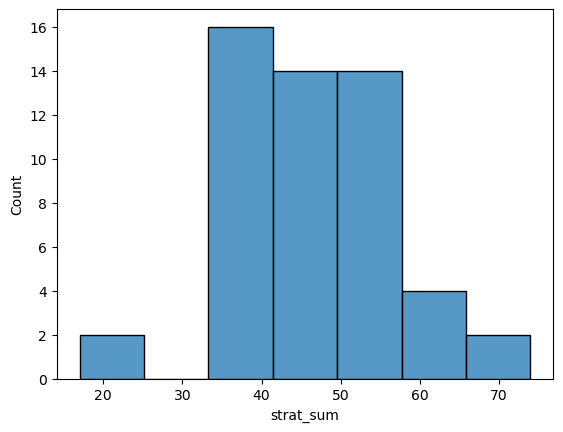

In [13]:
sns.histplot(df['strat_sum'])

In [14]:
df1.columns

Index(['квота сек', 'Слово', 'Предыдущее + слово', 'Первая_буква', 'Стратегия',
       'Порядок_буква', 'Порядок_весь_тест', 'Частотность', 'Пауза', 'VP',
       'VS', 'N of words', 'N of words_P', 'N of words_O', 'N of words_S',
       'Mean pause', 'type', 'strategyfreq_dict'],
      dtype='object')

In [15]:
analysis_df = df1[['квота сек', 'Первая_буква',
       'Порядок_буква', 'Порядок_весь_тест','Частотность', 'strategyfreq_dict','Пауза', 
       'Mean pause', 'type']]

analysis_df = pd.concat([analysis_df, dff], axis=1)

In [16]:
# analysis_df.head()

In [17]:
df.head()

,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum
ID,,,,,
pr_A_1,10.0,5.0,13.0,16,44.0
pr_B_1,10.0,3.0,16.0,22,51.0
pr_E_1,5.0,1.0,10.0,36,52.0
pr_G_1,14.0,1.0,7.0,33,55.0
pr_I_1,4.0,1.0,9.0,34,48.0


In [23]:
humans = df.join(df1[['type']])
humans.to_csv('strategies_counts.tsv', sep='\t')

In [24]:
humans_ = dff.join(df1[['type']])
humans_.to_csv('strategies_fractions.tsv', sep='\t')


In [25]:
df_names['Частотность'] = df_names['Частотность'].astype('float', errors = 'ignore')
df_names['Пауза'] = df_names['Пауза'].astype('float', errors='ignore' )

In [26]:

df_names['Mean pause'] = df_names['Mean pause'].str.replace(',', '.' ).astype('float')

In [27]:
df_names.columns

Index(['ID', 'квота сек', 'Слово', 'Предыдущее + слово', 'Первая_буква',
       'Стратегия', 'Порядок_буква', 'Порядок_весь_тест', 'Частотность',
       'Пауза', 'VP', 'VS', 'N of words', 'N of words_P', 'N of words_O',
       'N of words_S', 'Mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [28]:
words = df_names.copy()

In [29]:
words.columns = ['ID', 'quota sec', 'word', 'previous + word', 'first_letter',
'strategy', 'order_letter', 'order_whole_test', 'frequency',
'pause', 'VP', 'VS', 'N of words', 'N of words_P', 'N of words_O',
'N of words_S', 'mean pause', 'type', 'strategy_name',
'strategy_paper_name']

In [30]:
words.head()

,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,pause,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,Б_В_10,1,пара,NaN,п,nan,1,1,152.7,NaN,NaN,NaN,59,28,13,18,2.390357,students,None,None
1,Б_В_10,1,период,"[пара, период]",п,8,2,2,204.2,0.10,NaN,NaN,59,28,13,18,2.390357,students,individual association strategy,S4
2,Б_В_10,1,парад,"[период, парад]",п,11,3,3,13.2,3.15,1.0,NaN,59,28,13,18,2.390357,students,phonetic strategy,S1
3,Б_В_10,1,предлог,"[парад, предлог]",п,8,4,4,12.7,1.00,1.0,NaN,59,28,13,18,2.390357,students,individual association strategy,S4
4,Б_В_10,1,по,"[предлог, по]",п,3,5,5,5786.7,0.70,NaN,NaN,59,28,13,18,2.390357,students,semantic-field strategy,S3


In [31]:
words.to_csv('words.tsv', sep='\t')

In [32]:
words.to_excel('words.xlsx', index=False)

# rt

In [33]:
rt = pd.read_csv('results_academic_student.csv', sep=';')

In [34]:
rt.group.unique()

array(['senior academics', 'students'], dtype=object)

In [35]:
rt.head()

,participant,mean_rt,group
0,12014,0.608103,senior academics
1,2001,0.537719,senior academics
2,2005,0.863233,senior academics
3,9001,0.801409,senior academics
4,9002,0.564224,senior academics
